📘 Susnata's Introduction

Traditional demand forecasting models focus on predicting a single average outcome. While this approach is useful for reporting, it often fails in real-world operations where uncertainty, risk, and asymmetric costs dominate decision-making.

Motivation of Project- An Industry leader and mentor who is helping Cadbuary one of worlds latgest chocolate maker to forecast

Similarly , In a bike rental business, predicting the average number of rentals is rarely sufficient. Underestimating demand leads to stockouts, lost revenue, and poor customer experience, while overestimating demand results in idle inventory and unnecessary operational costs. These two errors are not equally expensive — yet most classical models treat them as if they are.

This notebook approaches the problem from a decision-first perspective rather than a purely accuracy-driven one.

Instead of asking:

“What is the average number of bikes rented?”

I ask:

“How many bikes should be available to be safe, aggressive, or balanced under uncertainty?”

To answer this, we use Quantile Regression, a modeling framework that estimates different conditional demand levels (e.g., 10th, 50th, and 90th percentiles) rather than a single mean prediction. This allows us to explicitly model best-case, typical, and worst-case demand scenarios, enabling risk-aware operational planning.

Using a real bike rental dataset and weather-related features, this notebook:

Demonstrates why traditional metrics like RMSE and R² are insufficient for decision-making under uncertainty

Shows how quantile regression captures asymmetric risk and heteroskedastic demand patterns

Visualizes uncertainty through prediction intervals rather than point estimates

Evaluates models using quantile-consistent metrics such as coverage and pinball loss

The goal of this notebook is not to maximize predictive accuracy, but to make uncertainty explicit, interpretable, and actionable — transforming demand forecasting from a statistical exercise into a business decision tool.

My data https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, QuantileRegressor

QuantileRegressor → pinball loss

LinearRegression → mean baseline

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


These are continuous, weather-driven drivers

Demand is noisy → perfect for quantiles

I intentionally avoided

season

hour

holiday

I am modelling Given weather, what demand could happen? so took temp humidity and windspeed as X

In [3]:
df = pd.read_csv("train.csv")

X = df[["temp", "humidity", "windspeed"]]
y = df["count"]

Quantile regression is linear under the hood

Scaling improves:

convergence

numerical stability

coefficient comparability

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

I am training four planners:

Linear Regression → average planner

q = 0.1 → aggressive planner (cost-cutting)

q = 0.5 → typical-day planner

q = 0.9 → safety-first planner

Quantile = 0.1
QuantileRegressor(quantile=0.1)


Predicts 10th percentile

90% of time, actual demand will be above this

Cost-cutting strategy

Risky but cheap 💸

Quantile = 0.5 Median
QuantileRegressor(quantile=0.5)


Predicts median

Robust to outliers

Optimizes absolute loss

This is NOT the mean

📌 Please note thats its Important:

Median ≠ Mean (when distribution is skewed)

Quantile = 0.9 (Safety-first)
QuantileRegressor(quantile=0.9)


Predicts demand level that covers 90% scenarios

Stock buffers

SLA protection

Higher cost, lower regret

In [5]:
lr = LinearRegression().fit(X_train_s, y_train)

qr_10 = QuantileRegressor(quantile=0.1).fit(X_train_s, y_train)
qr_50 = QuantileRegressor(quantile=0.5).fit(X_train_s, y_train)
qr_90 = QuantileRegressor(quantile=0.9).fit(X_train_s, y_train)

In [6]:
temp_range = np.linspace(X["temp"].min(), X["temp"].max(), 100)

X_plot = pd.DataFrame({
    "temp": temp_range,
    "humidity": X["humidity"].mean(),
    "windspeed": X["windspeed"].mean()
})

X_plot_s = scaler.transform(X_plot)

y_10 = qr_10.predict(X_plot_s)
y_50 = qr_50.predict(X_plot_s)
y_90 = qr_90.predict(X_plot_s)

This block is used to visualize and interpret the effect of temperature on demand across different risk levels using quantile regression, while keeping other environmental factors constant.

Instead of predicting a single average outcome, this code helps us understand:

Worst-case demand (10th percentile)

Typical demand (50th percentile)

High-demand scenarios (90th percentile)

This is critical for risk-aware decision making such as inventory planning, staffing, and SLA design.   

This is partial dependence,

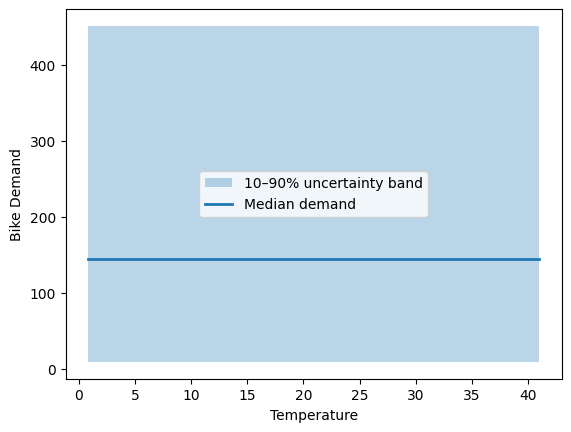

In [7]:
plt.figure()
plt.fill_between(temp_range, y_10, y_90, alpha=0.3, label="10–90% uncertainty band")
plt.plot(temp_range, y_50, label="Median demand", linewidth=2)
plt.xlabel("Temperature")
plt.ylabel("Bike Demand")
plt.legend()
plt.show()

This above  band tells me  how much demand can swing for the same weather.

In [8]:
y_pred_90 = qr_90.predict(X_test_s)
coverage_90 = np.mean(y_test <= y_pred_90)

coverage_90

np.float64(0.8939393939393939)

from the above i can say 90th percentile model actually covers ~89% of real demand

In [9]:
y_pred_10 = qr_10.predict(X_test_s)
interval_width = np.mean(y_pred_90 - y_pred_10)

interval_width

np.float64(442.0)

There is

High uncertainty

Weather alone can’t pin demand tightly

Operational buffers must be large

This justifies why i may need more  features later

 **pinball loss**

If prediction is too low → penalty = q * error

If prediction is too high → penalty = (q-1) * error

So:

q = 0.9 → underprediction is punished HARD

q = 0.1 → overprediction is punished HARD

 This is why my

Quantile regression tilts the loss asymmetrically

In [10]:
def pinball_loss(y_true, y_pred, q):
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))

pl_90 = pinball_loss(y_test, y_pred_90, q=0.9)
pl_50 = pinball_loss(y_test, qr_50.predict(X_test_s), q=0.5)

pl_90, pl_50

(np.float64(40.32929292929292), np.float64(68.89990817263545))

Residual = actual − predicted

So for quantile = 0.5 its below

This is median residual not mean

For a well-fitted median quantile model:

~50% residuals above 0

~50% residuals below 0

only weather features were used

Weather weakly explains the center of demand

Median demand is stable

Variability is mostly in the tails, not the center

q = 0.5 Quantile Regression = LAD Regression
LAD = Least Absolute Deviations

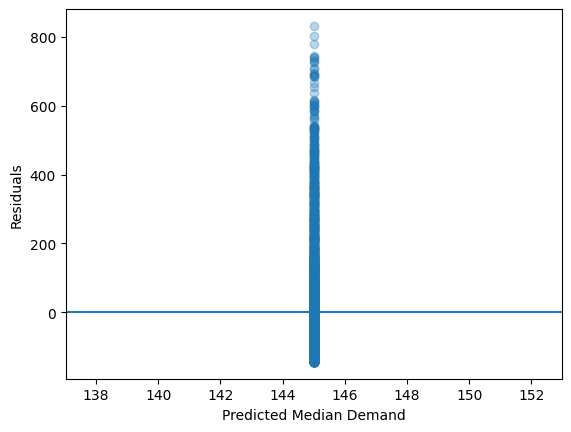

In [11]:
residuals = y_test - qr_50.predict(X_test_s)

plt.figure()
plt.scatter(qr_50.predict(X_test_s), residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted Median Demand")
plt.ylabel("Residuals")
plt.show()

In [13]:
mae_median = np.mean(np.abs(y_test - qr_50.predict(X_test_s)))
mae_median

#This is Mean Absolute Error (MAE) for the 50th percentile model.

np.float64(137.7998163452709)

From the above image Points above → underprediction

Points below → overprediction

All points form a vertical line because my  model predicts almost the same median demand across many situations

What this means is :

Median demand is stable

Variability happens around that median

Risk does not come from the center — it comes from extremes

My final takeaway


This above  plot shows that our model predicts a very stable median demand — around 145 bikes — regardless of weather.

However, actual demand often deviates significantly from this median, both above and below.

This tells us that while typical demand is predictable, risk lives in extreme scenarios, not in the average case.

Planning based only on the median would ignore high-demand surge days, which can cause stockouts.

This is exactly why we use quantile regression — to plan not just for the typical day, but for risky days as well.

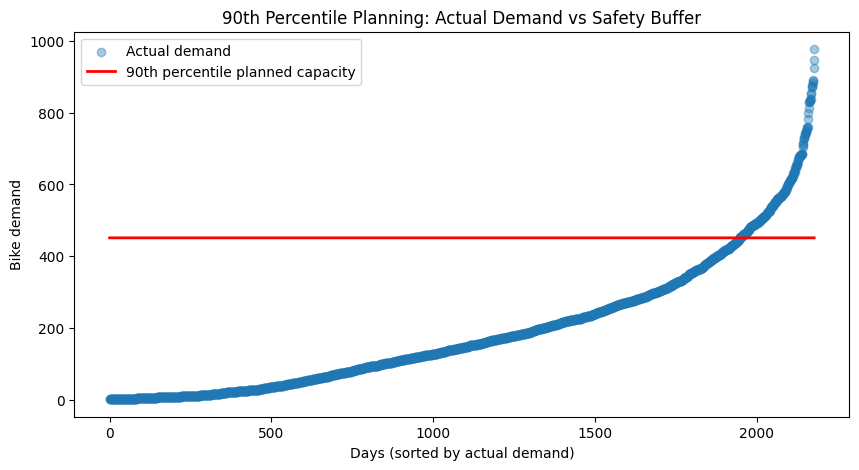

In [15]:
# Predicting 90th percentile on test set
y_pred_90 = qr_90.predict(X_test_s)

# Sorting by actual demand for nicer visualization
order = np.argsort(y_test.values)

y_test_sorted = y_test.values[order]
y_pred_90_sorted = y_pred_90[order]

plt.figure(figsize=(10, 5))

# Actual demand
plt.scatter(
    range(len(y_test_sorted)),
    y_test_sorted,
    alpha=0.4,
    label="Actual demand"
)

# 90th percentile safety line
plt.plot(
    range(len(y_test_sorted)),
    y_pred_90_sorted,
    color="red",
    linewidth=2,
    label="90th percentile planned capacity"
)

plt.xlabel("Days (sorted by actual demand)")
plt.ylabel("Bike demand")
plt.title("90th Percentile Planning: Actual Demand vs Safety Buffer")
plt.legend()
plt.show()

A 90th percentile prediction means the actual value will be LESS THAN OR EQUAL TO the prediction about 90% of the time.

Dots ABOVE the red line
were rare days where demand exceeded even our safety plan.

Our 90th percentile plan covers most days, with only a small number of extreme failures, which is exactly what we expect.”

This is quantile regression success.

In [14]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'q10_coef': qr_10.coef_,
    'q50_coef': qr_50.coef_,
    'q90_coef': qr_90.coef_
})

coef_df

,feature,q10_coef,q50_coef,q90_coef
0,temp,0.0,0.0,0.0
1,humidity,0.0,0.0,0.0
2,windspeed,0.0,0.0,0.0


Why are ALL coefficients = 0 ?


QuantileRegressor in sklearn uses L1 regularization by DEFAULT.

This is basically LASSO on steroids.



Fitting  WITHOUT regularization alpha 0

In [ ]:
from sklearn.linear_model import QuantileRegressor

qr_10 = QuantileRegressor(quantile=0.1, alpha=0)
qr_50 = QuantileRegressor(quantile=0.5, alpha=0)
qr_90 = QuantileRegressor(quantile=0.9, alpha=0)

qr_10.fit(X_train_s, y_train)
qr_50.fit(X_train_s, y_train)
qr_90.fit(X_train_s, y_train)

In [17]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "q10_coef": qr_10.coef_,
    "q50_coef": qr_50.coef_,
    "q90_coef": qr_90.coef_
})

intercepts = pd.DataFrame({
    "quantile": ["q10", "q50", "q90"],
    "intercept": [qr_10.intercept_, qr_50.intercept_, qr_90.intercept_]
})

coef_df, intercepts

(     feature   q10_coef   q50_coef    q90_coef
 0       temp  14.801808  65.675008  110.390251
 1   humidity -17.159249 -50.755773  -64.395325
 2  windspeed   1.437384   1.905651    1.194887,
   quantile   intercept
 0      q10   25.524482
 1      q50  157.667652
 2      q90  403.995136)

Instead of predicting a single demand number, we modeled a range of plausible demand outcomes.

This allows planners to choose strategies based on risk tolerance:

cost-cutting (10th percentile),

balanced (median),

or safety-first (90th percentile).

Traditional metrics like RMSE and R² fail here because they ignore asymmetric costs.
Quantile regression directly optimizes business risk using asymmetric loss.

The results show that weather alone introduces high uncertainty, justifying buffer-based planning and future feature enrichment.

Quantile regression is linear in parameters, not linear in outcomes